In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

best_exp = rs.get_best_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    device="cuda"
)
best_exp.build_dataloader()

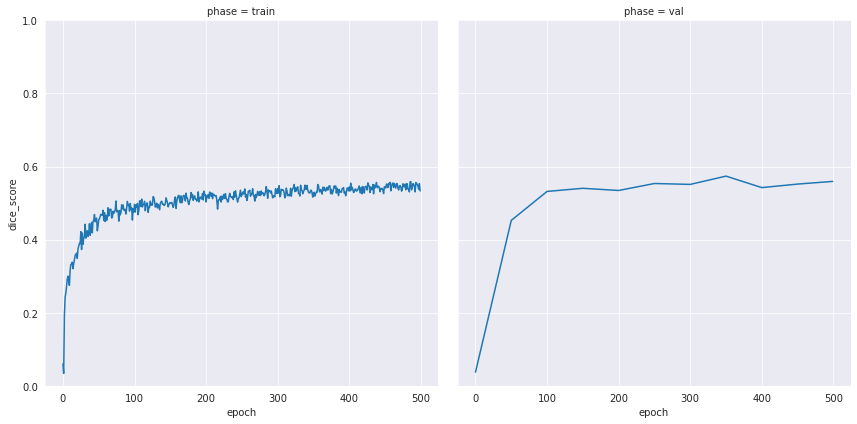

In [4]:
best_exp.vis_loss_curves(height=6)

In [5]:
from ese.experiment.analysis.inference import get_dataset_perf 

# val_perf is a dict where each item is the subj id
predictions_list = get_dataset_perf(
    exp=best_exp, 
    split="val"
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
from ese.experiment.analysis.inference import get_pixelinfo_df

pixel_preds_df = get_pixelinfo_df(
    data_points=predictions_list,
    num_bins=10,
    num_labels=2
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [7]:
# Define a custom palette
unique_labels = pixel_preds_df['label'].unique()
palette_colors = sns.color_palette('viridis', n_colors=len(unique_labels))  # -1 because we'll assign a distinct color to 'avg'
palette_dict = {label: color for label, color in zip(unique_labels, palette_colors)}
palette_dict['avg'] = 'gray'  # Assigning red color for 'avg' label

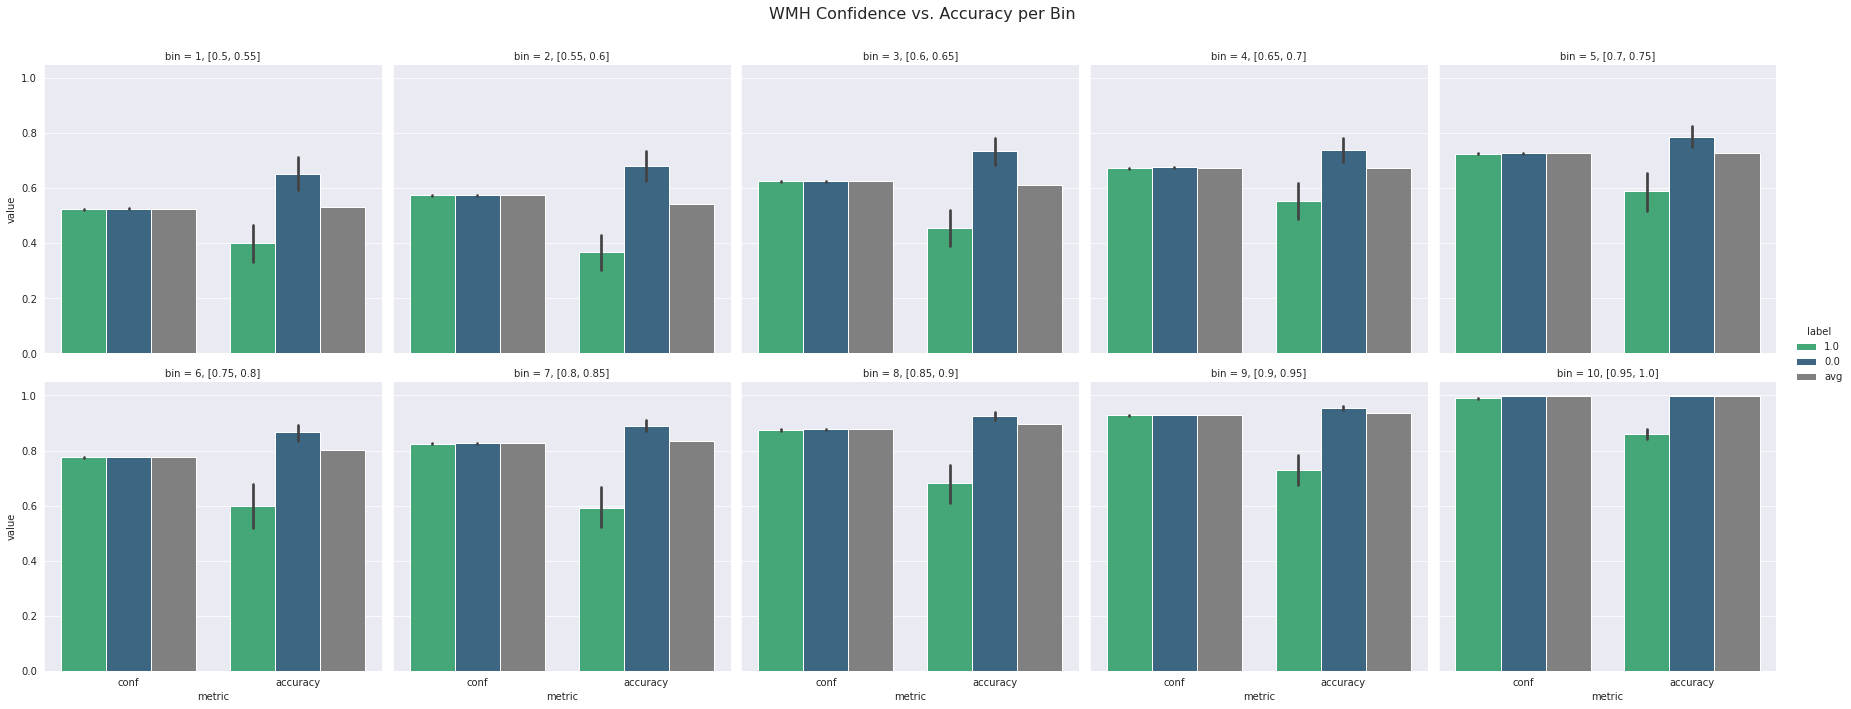

In [8]:
from ese.experiment.analysis.err_diagrams import viz_accuracy_vs_confidence

viz_accuracy_vs_confidence(
    pixel_preds_df,
    per_label=True,
    per_bin=True,
    label_palette=palette_dict
    )

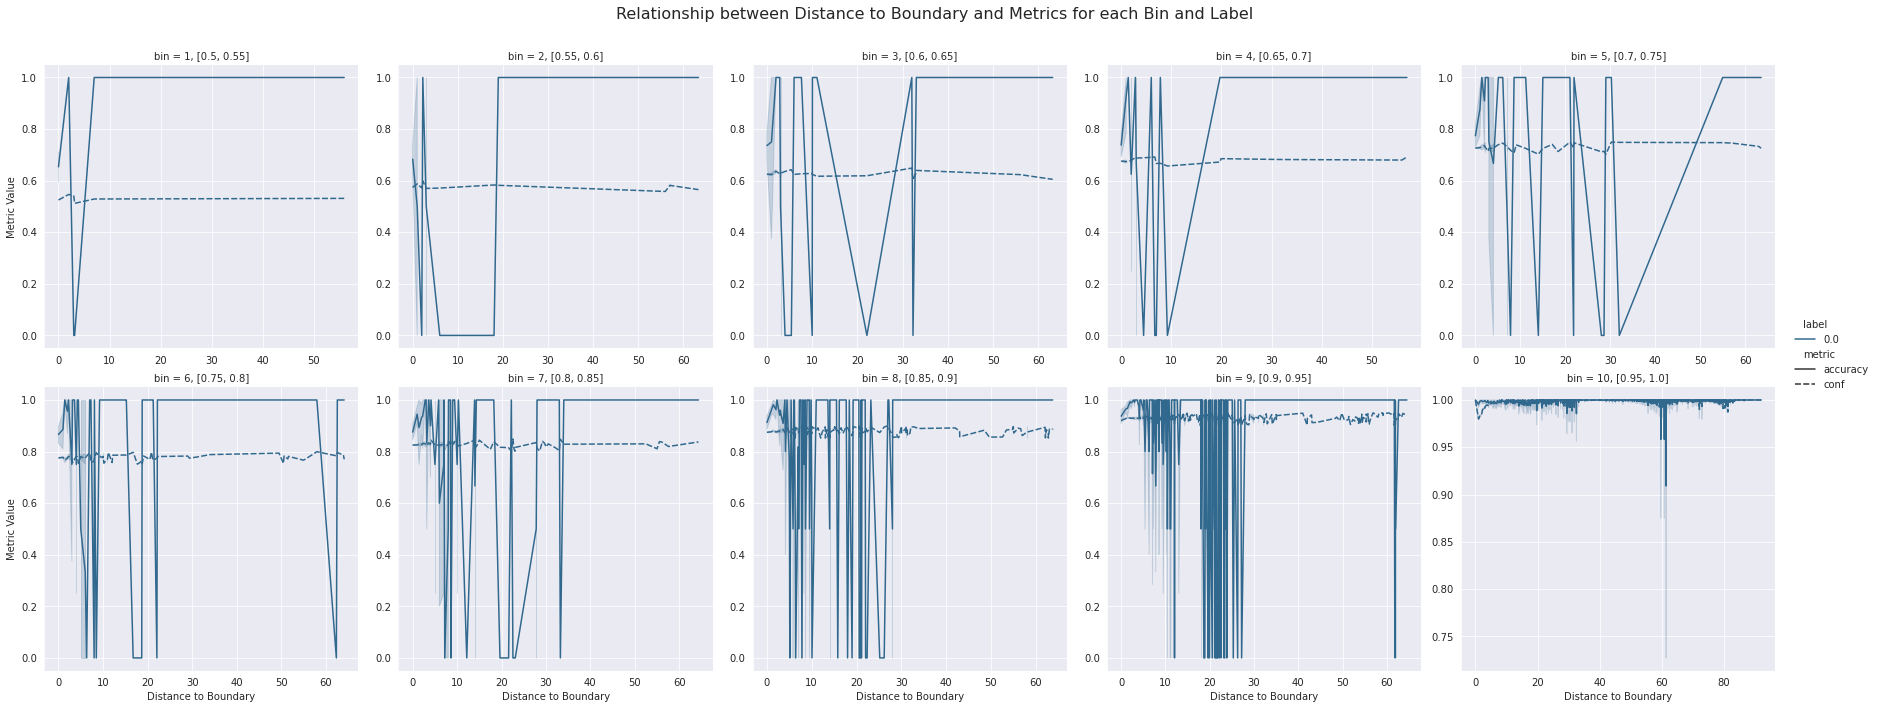

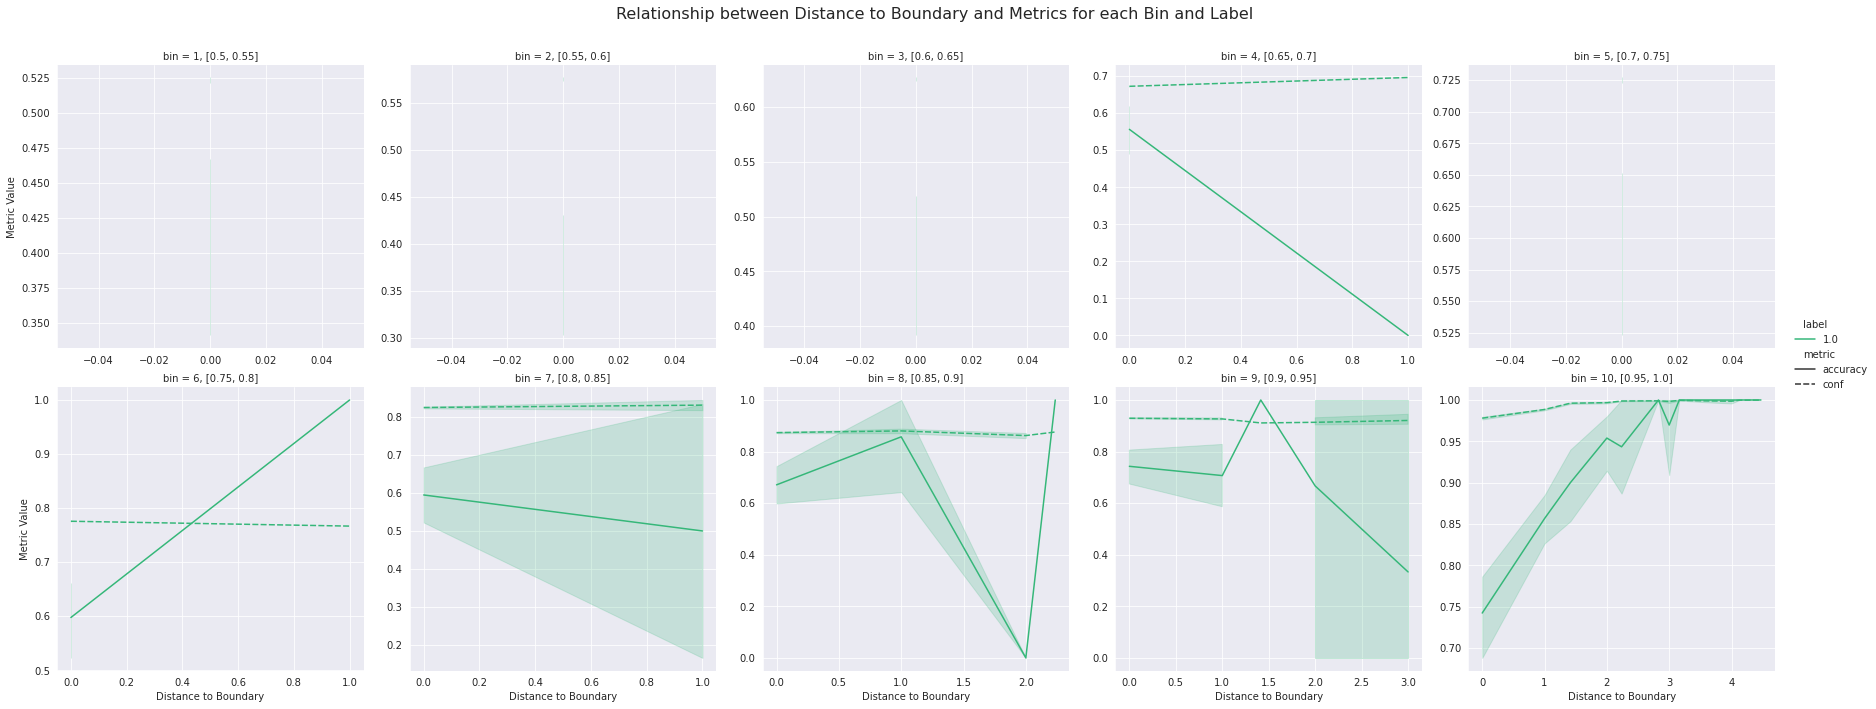

In [9]:
import pandas as pd

# Melt dataframe to combine 'accuracy' and 'confidence' into a single column.
pixel_preds_df_melted = pd.melt(pixel_preds_df, 
                    id_vars=['bin', 'bin_num', 'label', 'dist to boundary'], 
                    value_vars=['accuracy', 'conf'], 
                    var_name='metric', 
                    value_name='value'
                    )
pixel_preds_df_melted = pixel_preds_df_melted.sort_values('bin_num')
for label in pixel_preds_df["label"].unique():
    # Create the relplot
    g = sns.relplot(data=pixel_preds_df_melted[pixel_preds_df_melted['label'] == label],
                    x='dist to boundary',
                    y='value',
                    hue='label',
                    style='metric',
                    col='bin',
                    col_wrap=5,
                    kind='line',  # Ensure it plots lines, not scatter points
                    palette=palette_dict,
                    facet_kws={'sharey': False, 'sharex': False})

    # Adjusting the y-label to be more informative since 'value' is too generic
    g.set_axis_labels("Distance to Boundary", "Metric Value")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Relationship between Distance to Boundary and Metrics for each Bin and Label', fontsize=16)
    # Show the plot.
    plt.show()